In [1]:
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


# Experiment tracking

In [42]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

from pathlib import Path

from modular import data_setup, engine, utils
from helper_functions import download_data

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

utils.set_seeds()

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x25a46ddb610>,
 ['pizza', 'steak', 'sushi'])

In [4]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [5]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
utils.set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [6]:
# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [7]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Adjust train() function to track results with SummaryWriter()

In [8]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

utils.set_seeds()

results = engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5,
                        device=device,
                        tensorboard_writer=writer,
                        input_example=torch.randn(32, 3, 224, 224))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0801 | train_acc: 0.4297 | test_loss: 0.8797 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.8870 | train_acc: 0.6523 | test_loss: 0.7729 | test_acc: 0.8049
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.7422 | test_loss: 0.6622 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.6981 | train_acc: 0.7344 | test_loss: 0.6550 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6382 | train_acc: 0.8750 | test_loss: 0.6477 | test_acc: 0.7945


In [9]:
# Create an example writer
example_writer = utils.create_writer(experiment_name="data_10_percent",
                                    model_name="effnetb0",
                                    extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2023-08-16\data_10_percent\effnetb0\5_epochs...


### Setting up multiple experiments

In [11]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [12]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [13]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [14]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


We can find the input and output shapes of EffNetB2 using torchinfo.summary() and passing in the input_size=(32, 3, 224, 224) parameter ((32, 3, 224, 224) is equivalent to (batch_size, color_channels, height, width), i.e we pass in an example of what a single batch of data would be to our model).

In [22]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}") 

Number of in_features to final layer of EfficientNetB2: 1408


In [25]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    utils.set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    utils.set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [26]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [27]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [34]:
%%time
from modular.utils import save_model

# 1. Set the random seeds
utils.set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # create a new tensorboard writer
            tb_writer = utils.create_writer(experiment_name=dataloader_name,
                                                    model_name=model_name,
                                                    extra=f"{epochs}_epochs")

            # 9. Train target model with target dataloaders and track experiments
            engine.train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  tensorboard_writer=tb_writer,
                  input_example=torch.randn(32, 3, 224, 224)
            )
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-08-16\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0366 | train_acc: 0.4258 | test_loss: 0.8819 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9300 | train_acc: 0.6094 | test_loss: 0.7335 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7567 | train_acc: 0.7461 | test_loss: 0.7125 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7019 | train_acc: 0.7344 | test_loss: 0.6118 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6299 | train_acc: 0.7852 | test_loss: 0.5974 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-08-16\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0628 | train_acc: 0.3438 | test_loss: 0.9261 | test_acc: 0.7112
Epoch: 2 | train_loss: 0.9647 | train_acc: 0.5938 | test_loss: 0.7960 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.7682 | train_acc: 0.8398 | test_loss: 0.7766 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.7061 | train_acc: 0.9062 | test_loss: 0.6999 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.6167 | train_acc: 0.8867 | test_loss: 0.6302 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-08-16\data_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0366 | train_acc: 0.4258 | test_loss: 0.8819 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9300 | train_acc: 0.6094 | test_loss: 0.7335 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7567 | train_acc: 0.7461 | test_loss: 0.7125 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7019 | train_acc: 0.7344 | test_loss: 0.6118 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6299 | train_acc: 0.7852 | test_loss: 0.5974 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.6365 | train_acc: 0.7734 | test_loss: 0.6078 | test_acc: 0.8163
Epoch: 7 | train_loss: 0.5724 | train_acc: 0.8086 | test_loss: 0.4995 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5074 | train_acc: 0.9180 | test_loss: 0.4825 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.5684 | train_acc: 0.8164 | test_loss: 0.4946 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.4537 | train_acc: 0.9453 | test_loss: 0.5084 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0628 | train_acc: 0.3438 | test_loss: 0.9261 | test_acc: 0.7112
Epoch: 2 | train_loss: 0.9647 | train_acc: 0.5938 | test_loss: 0.7960 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.7682 | train_acc: 0.8398 | test_loss: 0.7766 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.7061 | train_acc: 0.9062 | test_loss: 0.6999 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.6167 | train_acc: 0.8867 | test_loss: 0.6302 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.5868 | train_acc: 0.8594 | test_loss: 0.5881 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.6288 | train_acc: 0.7773 | test_loss: 0.5674 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5332 | train_acc: 0.7969 | test_loss: 0.5751 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.4715 | train_acc: 0.9531 | test_loss: 0.5909 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.5350 | train_acc: 0.7734 | test_loss: 0.5944 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9930 | train_acc: 0.4938 | test_loss: 0.7114 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.7089 | train_acc: 0.7604 | test_loss: 0.5993 | test_acc: 0.8466
Epoch: 3 | train_loss: 0.6154 | train_acc: 0.7896 | test_loss: 0.5083 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5524 | train_acc: 0.8125 | test_loss: 0.4128 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8438 | test_loss: 0.4094 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-08-16\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9941 | train_acc: 0.5146 | test_loss: 0.8027 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7293 | train_acc: 0.7917 | test_loss: 0.6769 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.6079 | train_acc: 0.8333 | test_loss: 0.5729 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5039 | train_acc: 0.8771 | test_loss: 0.5390 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4646 | train_acc: 0.9021 | test_loss: 0.4886 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-08-16\data_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9930 | train_acc: 0.4938 | test_loss: 0.7114 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.7089 | train_acc: 0.7604 | test_loss: 0.5993 | test_acc: 0.8466
Epoch: 3 | train_loss: 0.6154 | train_acc: 0.7896 | test_loss: 0.5083 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5524 | train_acc: 0.8125 | test_loss: 0.4128 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8438 | test_loss: 0.4094 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3719 | train_acc: 0.9313 | test_loss: 0.3634 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.4384 | train_acc: 0.8375 | test_loss: 0.3424 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3711 | train_acc: 0.8875 | test_loss: 0.3418 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.3831 | train_acc: 0.8604 | test_loss: 0.2972 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3539 | train_acc: 0.8729 | test_loss: 0.3043 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9941 | train_acc: 0.5146 | test_loss: 0.8027 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7293 | train_acc: 0.7917 | test_loss: 0.6769 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.6079 | train_acc: 0.8333 | test_loss: 0.5729 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5039 | train_acc: 0.8771 | test_loss: 0.5390 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4646 | train_acc: 0.9021 | test_loss: 0.4886 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4258 | train_acc: 0.9104 | test_loss: 0.4520 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.4302 | train_acc: 0.8875 | test_loss: 0.4481 | test_acc: 0.8674
Epoch: 8 | train_loss: 0.4328 | train_acc: 0.8521 | test_loss: 0.3995 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3669 | train_acc: 0.8854 | test_loss: 0.4171 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.4288 | train_acc: 0.8146 | test_loss: 0.3904 | test_acc: 0.9081
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

### Choosing mest model and making predictions

In [35]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [36]:
# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


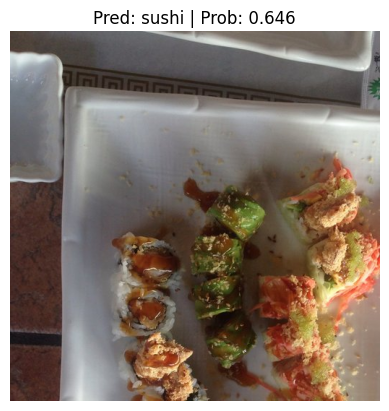

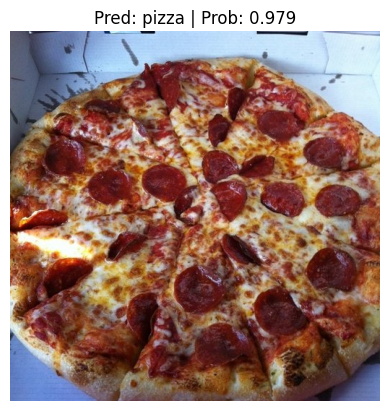

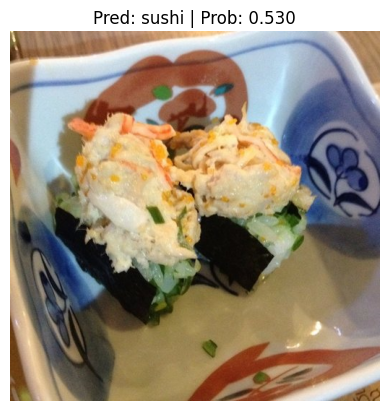

In [45]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

Test accuracy: 0.9081439393939394


Predicting:   0%|          | 0/3 [00:00<?, ?it/s]

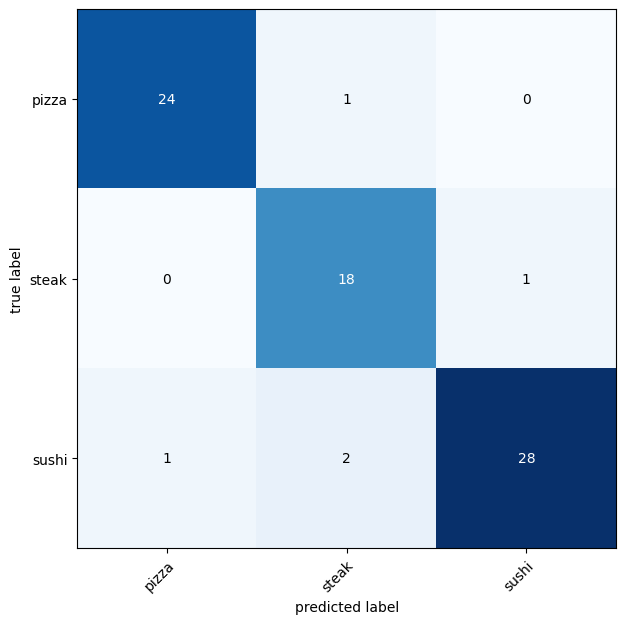

In [72]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.autonotebook import tqdm
from modular.engine import test_step

t_loss, t_acc = test_step(model=best_model, 
                        dataloader=test_dataloader, 
                        loss_fn=loss_fn, 
device=device)
print(f"Test accuracy: {t_acc}")

y_target = []
y_preds = []
best_model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Predicting"):
        X, y = X.to(device), y.to(device)
        
        y_logit = best_model(X)
        y_pred = y_logit.argmax(dim=1)

        y_preds.append(y_pred.cpu())
        y_target.append(y.cpu())

y_pred_tensor = torch.cat(y_preds)
y_target_tensor = torch.cat(y_target)

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=y_target_tensor)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7)
 )


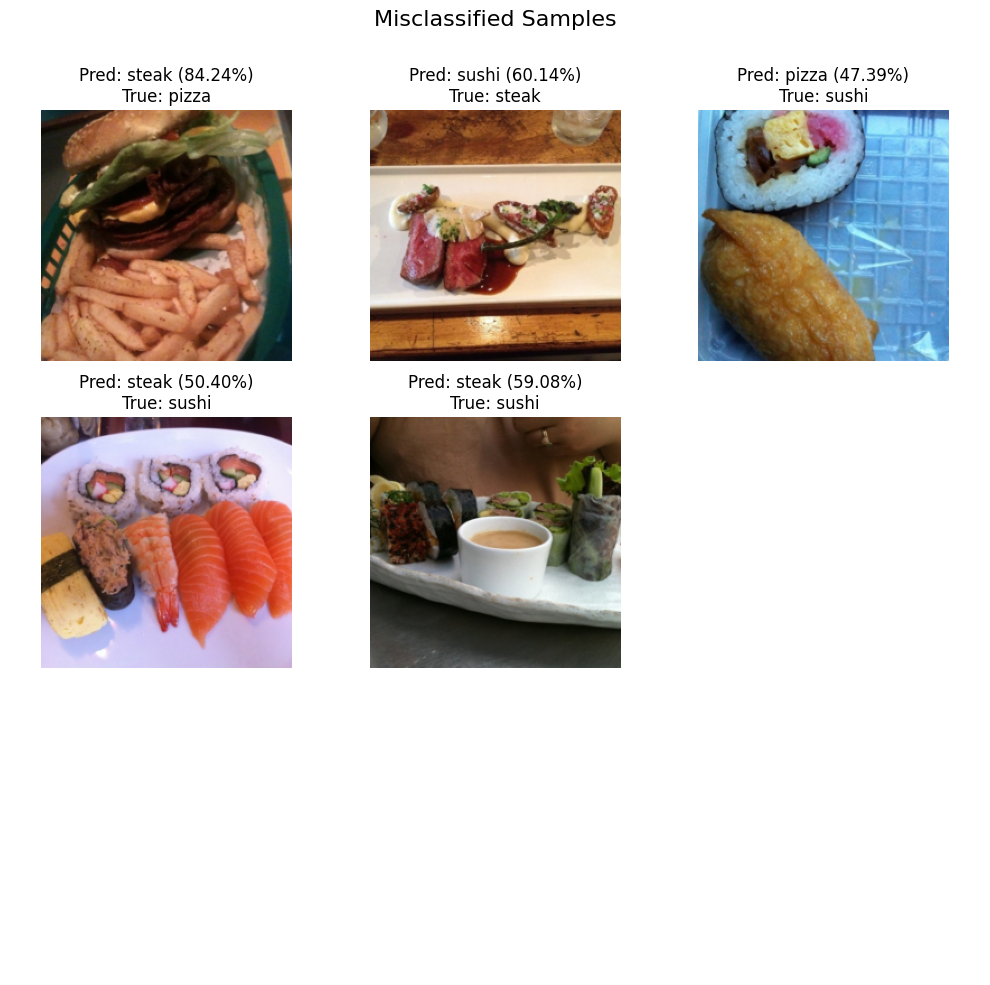

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `test_dataloader` returns image tensors of shape (batch_size, channels, height, width)
# and you're using 3 channels (RGB)
misclassified_idx = (y_pred_tensor != y_target_tensor).nonzero(as_tuple=True)[0]

# Take up to 9 misclassified indices
selected_idx = misclassified_idx[:9]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Misclassified Samples', fontsize=16)
axes = axes.ravel()

# setup inverse transform
mean = torch.tensor([0.485, 0.456, 0.406])  # replace with your values
std = torch.tensor([0.229, 0.224, 0.225])   # replace with your values

def denormalize(image, mean, std):
    image = image * std + mean
    image = image.clip(0, 1)
    return image

for i, idx in enumerate(selected_idx):
    # Get the corresponding image and true/predicted labels
    img, true_label = test_dataloader.dataset[idx]
    
    pred_label = y_pred_tensor[idx]
    prediction_percentage = torch.softmax(model(img.unsqueeze(0).to(device)).squeeze(), dim=0)[pred_label].item() * 100

    img = img.permute(1, 2, 0)
    img = denormalize(img, mean, std)

    # Plot the image
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {class_names[pred_label]} ({prediction_percentage:.2f}%)\nTrue: {class_names[true_label]}")
    axes[i].axis('off')

# Handle cases where there might be less than 9 misclassified samples
for j in range(i+1, 9):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # adjust suptitle position
plt.show()


### Inspecting probabilities

In [60]:
img, true_label = test_dataloader.dataset[idx]
pred_label = y_pred_tensor[idx]
prediction_percentage = torch.softmax(model(img.unsqueeze(0).to(device)).squeeze(), dim=0)[pred_label].item() * 100

In [62]:
img.shape

torch.Size([3, 224, 224])

In [63]:
pred_label

tensor(1)

In [68]:
model(img.unsqueeze(0).to(device))

tensor([[-0.8170,  0.5582, -0.2634]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [69]:
torch.softmax(model(img.unsqueeze(0).to(device)).squeeze(), dim=0)

tensor([0.1494, 0.5908, 0.2598], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [70]:
torch.softmax(model(img.unsqueeze(0).to(device)).squeeze(), dim=0)[pred_label].item()

0.590846598148346